# **Prevendo preços de carros usados**

A partir de um dataset do Kaggle, vamos criar um modelo de regressão para predição de preços de carros usados

### Explorando o Dataset

In [1]:
#Importação de bibliotecas básicas necessárias para o desenvolvimento do projeto
import pandas as pd
import numpy as np

#Definindo um dataframe a partir do arquivo csv
df_carros = pd.read_csv('used_cars.csv')

In [2]:
#Visualizando características básicas do dataframe
df_carros.head()


Unnamed: 0   model  year  price transmission  mileage fuelType  tax   mpg  \
0           0   T-Roc  2019  25000    Automatic    13904   Diesel  145  49.6   
1           1   T-Roc  2019  26883    Automatic     4562   Diesel  145  49.6   
2           2   T-Roc  2019  20000       Manual     7414   Diesel  145  50.4   
3           3   T-Roc  2019  33492    Automatic     4825   Petrol  145  32.5   
4           4   T-Roc  2019  22900    Semi-Auto     6500   Petrol  150  39.8   

   engineSize Make  
0         2.0   VW  
1         2.0   VW  
2         2.0   VW  
3         2.0   VW  
4         1.5   VW

In [3]:
#A primeira coluna trata-se de um índice, logo podemos removê-la
df_carros.drop(columns = 'Unnamed: 0', inplace=True)


#Importa biblioteca necessária para randomizar o dataframe
from sklearn.utils import shuffle
#Embaralha os dados para evitar enviesamento por organização do dataset
df_carros = shuffle(df_carros, random_state=42)

#Além disso, a coluna da variável dependente é 'price', e podemos separá-la do restante do dataframe
y = df_carros['price']
x = df_carros.drop(columns = 'price')

## Limpeza de dados

In [4]:
#Primeiramente, vamos identificar se há alguma coluna com excesso de dados nulos
x.isnull().sum()

model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
Make            0
dtype: int64

In [5]:
#Como não há dados nulos, não precisaremos tratar esse tipo de dado. Vamos agora visualizar as
#características básicas do dataframe

#Visualizando os tipos de dados em cada coluna
print(df_carros.dtypes)

#Visualizando uma descrição estatística básica
display(df_carros.describe())

model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
Make             object
dtype: object


year          price        mileage           tax           mpg  \
count  99187.000000   99187.000000   99187.000000  99187.000000  99187.000000   
mean    2017.087723   16805.347656   23058.914213    120.299838     55.166825   
std        2.123934    9866.773417   21148.523721     63.150926     16.138522   
min     1970.000000     450.000000       1.000000      0.000000      0.300000   
25%     2016.000000    9999.000000    7425.000000    125.000000     47.100000   
50%     2017.000000   14495.000000   17460.000000    145.000000     54.300000   
75%     2019.000000   20870.000000   32339.000000    145.000000     62.800000   
max     2060.000000  159999.000000  323000.000000    580.000000    470.800000   

         engineSize  
count  99187.000000  
mean       1.663280  
std        0.557646  
min        0.000000  
25%        1.200000  
50%        1.600000  
75%        2.000000  
max        6.600000

In [6]:
'''
Abordaremos coluna a coluna

Year: Os valores de média e mínimo fazem sentido, já que, mesmo que este seja 1970, consideravelmente antigo, é
possível um carro ser desse ano. Já o valor máximo não faz sentido. Precisaremos investigar quantos registros
possuem um ano superior ao atual'''

#Visualizando distribuição de ocorrências de cada ano
x['year'].value_counts()

2019    26771
2017    21733
2016    15850
2018    13664
2015     7645
2020     4465
2014     4085
2013     2603
2012      634
2011      432
2010      340
2009      278
2008      200
2007      163
2006       86
2005       69
2004       52
2003       34
2002       31
2001       20
2000        9
1998        8
1999        6
1997        4
1996        2
1970        2
2060        1
Name: year, dtype: int64

In [7]:
#Vemos que o ano máximo imediatamente antes de 2060 é 2020. Logo, vamos supor que esse dataset tenha sido construído
#nesse ano e criar uma coluna chamada 'idade' para o tempo de vida do carro. Com relação ao outlier, vamos removê-lo.
#Como é apenas um registro, não causará impacto em nossa análise
x['idade'] = 2020 - x['year']

#Podemos remover a coluna 'year' neste momento
x.drop(columns = 'year', inplace=True)

In [8]:
#Com relação às outras colunas, apenas a 'mileage' apresenta dados curiosos. Como por exemplo o mínimo de apenas 1.
#Considerando que são carros usados, vale a pena averiguar mais a fundo

#Selecionando amostra suspeita e descrevendo-a estatisticamente
x[x['mileage']<100].describe()

mileage          tax          mpg   engineSize        idade
count  2435.000000  2435.000000  2435.000000  2435.000000  2435.000000
mean     21.264476   145.558522    49.126982     1.703162     0.691992
std      20.940987    11.742940    13.578723     0.570317     0.785288
min       1.000000     0.000000     2.800000     0.000000     0.000000
25%      10.000000   145.000000    42.200000     1.200000     0.000000
50%      11.000000   145.000000    48.700000     1.600000     1.000000
75%      25.000000   145.000000    54.300000     2.000000     1.000000
max      99.000000   325.000000   201.800000     5.500000    19.000000

In [9]:
#Percebemos que boa parte possue idade máxima de 1 ano. Vamos considerar esses casos como carros semi-novos
#Os outros vamos olhar com mais atenção

#Visualizando carros com idade considerável e baixa quilometragem
x[(x['mileage']<100) & (x['idade']>2)]

model transmission  mileage fuelType  tax   mpg  engineSize  \
80452         X5    Automatic       10   Diesel  145  47.1         3.0   
66906     Fiesta       Manual        1   Petrol  145  65.7         1.0   
80422   1 Series       Manual       10   Diesel   20  68.9         2.0   
80407         X5    Automatic       10   Diesel  145  47.1         3.0   
80438         X1    Semi-Auto       10   Petrol  160  44.8         2.0   
5246        Golf       Manual        1   Diesel  145  53.3         1.9   
80436   4 Series    Automatic       10   Petrol  200  41.5         3.0   
19672      Astra    Semi-Auto        1   Petrol  125  51.4         1.4   
80385         X5    Automatic       10   Diesel  145  42.8         3.0   
80413         X5    Automatic       10   Diesel  200  47.1         3.0   
80458   1 Series       Manual       10   Diesel   20  68.9         2.0   
13323     Beetle    Automatic        1   Petrol  325  29.7         2.0   
80410   1 Series       Manual       10   Petrol  125  53.3         1.5   
38878      Rapid       Manual       83   Diesel  150  67.3         1.6   
76679     Mondeo       Manual        1   Diesel  200  47.9         2.0   
56279        I20       Manual       11   Petrol   30  55.4         1.2   
9867        Polo       Manual        1   Petrol   20  60.1         1.2   
80439   1 Series       Manual       10   Petrol  125  53.3         1.5   
80454   2 Series    Semi-Auto       10   Petrol  145  52.3         1.5   
80371   1 Series       Manual       10   Diesel   20  72.4         1.5   
80370   1 Series    Semi-Auto       10   Diesel   20  68.9         1.5   
5605      Passat    Automatic       80   Diesel  150  54.3         2.0   
80453   2 Series       Manual       10   Diesel  145  64.2         2.0   
14987      Jetta       Manual        1   Diesel   20  67.3         1.6   
80409   1 Series       Manual       10   Diesel   20  72.4         1.5   
45201    C Class    Automatic       10   Diesel   20  64.2         2.1   
80437         X1       Manual       10   Diesel   20  68.9         2.0   
80388   1 Series       Manual       10   Diesel    0  78.5         1.5   
80435   4 Series       Manual       10   Petrol  160  46.3         2.0   
66703     Fiesta       Manual        1   Petrol  145  65.7         1.0   

           Make  idade  
80452       BMW      3  
66906      ford      3  
80422       BMW      4  
80407       BMW      3  
80438       BMW      3  
5246         VW     12  
80436       BMW      3  
19672  vauxhall      3  
80385       BMW      3  
80413       BMW      3  
80458       BMW      4  
13323        VW     19  
80410       BMW      4  
38878     skoda      3  
76679      ford     12  
56279    hyundi      4  
9867         VW      4  
80439       BMW      3  
80454       BMW      3  
80371       BMW      4  
80370       BMW      4  
5605         VW      6  
80453       BMW      3  
14987        VW      6  
80409       BMW      4  
45201      merc      6  
80437       BMW      3  
80388       BMW      4  
80435       BMW      4  
66703      ford      3

In [10]:
#Boa parte desses veículos é da marca BMW. Uma investigação mais profunda seria interessante, pois
#talvez algum fator desse mercado tenha relação com esse fato, como carros dessa marca serem mais
#colecionáveis que práticos, ou sua quilometragem ser de fácil manipulação. Como o objetivo deste
#projeto é apenas ilustrar um modelo de machine learning, vamos deixar esses registros no dataframe

#Com relação às variáveis categóricas, vamos explorá-las com relação ao seu conteúdo
for coluna in ['model','transmission','fuelType','Make']:
  print('Ocorrências na coluna',coluna,'\n',x[coluna].value_counts(),'\n\n')

Ocorrências na coluna model 
  Fiesta     6557
 Golf       4863
 Focus      4588
 C Class    3747
 Corsa      3441
            ... 
 RS7           1
 Ranger        1
230            1
 Escort        1
 Accent        1
Name: model, Length: 195, dtype: int64 


Ocorrências na coluna transmission 
 Manual       56445
Semi-Auto    22677
Automatic    20056
Other            9
Name: transmission, dtype: int64 


Ocorrências na coluna fuelType 
 Petrol      54928
Diesel      40928
Hybrid       3078
Other         247
Electric        6
Name: fuelType, dtype: int64 


Ocorrências na coluna Make 
 ford        17965
VW          15157
vauxhall    13632
merc        13119
BMW         10781
Audi        10668
toyota       6738
skoda        6267
hyundi       4860
Name: Make, dtype: int64 




In [11]:
#Há modelos de carro que ocorrem apenas uma vez, porém isso não é anormal. Com relação às outras colunas,
#Há um número relativamente pequeno de categorias em cada uma. Precisamos rotular cada categoria numericamente,
#para que os modelos possam interpretar seus dados. Primeiro separaremos as nossas variáveis categóricas
#das numéricas


#Define um dataframe contendo somente as variáveis categóricas
x_categ = x[['model','transmission','fuelType','Make']]

#Define um dataframe contendo somente as variáveis numéricas
x_num = x.drop(columns = ['model','transmission','fuelType','Make'])

#Importa a biblioteca necessária para padronizar a escala
from sklearn.preprocessing import StandardScaler
#Instancia o padronizador
scaler = StandardScaler()
#Reescala os dados das variáveis numéricas
scaled_x = scaler.fit_transform(x_num)

#Aqui vamos obter as variáveis categóricas em formato "1" ou "0" para cada categoria.
for col in x_categ.columns:
  #Converte a coluna em questão para configuração binária
  dummies_temp = pd.get_dummies(x_categ[col])
  #Unifica o dataframe de variáveis binárias ao dataframe de variáveis numéricas
  x_num = pd.concat([x_num,dummies_temp], axis = 1)

# **Ajuste de modelo - DecisionTree**

In [12]:
#Importa as bibliotecas necessárias para o modelo
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#Já temos os dataframes de features (x) e de targets (y). Precisamos agora separar os dados em treino e teste.

#Reservaremos 80% dos dados para treino e os outros 20% para teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x_num, y, test_size=0.2, random_state=42)

#Instancia o modelo
decision_tree_model = DecisionTreeRegressor(random_state=42)

#Ajusta o modelo aos dados de treino
decision_tree_model.fit(x_treino, y_treino)

#Realiza as previsões para os dados de teste
previsoes = decision_tree_model.predict(x_teste)

#Define o desvio quadrático médio como critério para medir os erros
mse = mean_squared_error(y_teste, previsoes)
print("Desvio Quadrático Médio:", mse, '\n','Desvio Médio:',mse**0.5,'\n\n')

#Printa a importância relativa de cada feature para o modelo
importancia_features = decision_tree_model.feature_importances_
print("Feature Importances:")
for feature, importancia in zip(x_num.columns, importancia_features):
    print(feature, ":", importancia)


Desvio Quadrático Médio: 5771890.217327828 
 Desvio Médio: 2402.475851559767 


Feature Importances:
mileage : 0.043774701795826584
tax : 0.008309028169637987
mpg : 0.043495769947214546
engineSize : 0.26285535626551737
idade : 0.24134236227382586
 1 Series : 0.0010108686978169967
 2 Series : 0.0010060024168096365
 3 Series : 0.0006499486043663369
 4 Series : 0.0003328001314717381
 5 Series : 0.00042592687597279503
 6 Series : 0.0001198571860417772
 7 Series : 0.0007977815231399189
 8 Series : 0.000809544337531887
 A Class : 0.005074689814160336
 A1 : 0.0003881829507727179
 A2 : 0.0
 A3 : 0.00013608510805854
 A4 : 0.000222201720916439
 A5 : 0.0002754570445622626
 A6 : 0.0005004250309153442
 A7 : 0.0002824489606556613
 A8 : 5.1344499187362434e-05
 Accent : 2.930693117633228e-08
 Adam : 0.0002979182272705936
 Agila : 8.263018876161023e-07
 Amarok : 3.601063705953366e-05
 Amica : 1.755034020050194e-07
 Ampera : 0.0
 Antara : 6.358799844649306e-07
 Arteon : 6.35754194809056e-05
 Astra : 0.0

In [ ]:
'''
O valor obtido para o erro médio em cada estimativa é de $ 2400. Lembrando que a média dos preços
dos automóveis é de R$ 16.000,00. Ou seja, temos um erro de mais de 15% em média.

Antes de avaliar o impacto de cada feature no modelo, vamos tentar melhorar nossos resultados.
'''

In [14]:
#Inicialmente, manteremos o mesmo algoritmo, e vamos variar seus hiperparâmetros. Dentre eles:
#1) max_depth nos valores [2,4,8,16,32,64,128]
#2) min_samples_split [2,4,8,16,32,64,128]
#3) min_samples_leaf [2,4,8,16,32,64,128]

def executa_decisiontree(max_depth,min_samples_split,min_samples_leaf):

  #O trecho abaixo apenas repete o que já foi exposto, tornando os hiperparâmetros variáveis
  decision_tree_model = DecisionTreeRegressor(max_depth=max_depth,min_samples_split=min_samples_split,
                                              min_samples_leaf=min_samples_leaf,random_state=42)
  decision_tree_model.fit(x_treino, y_treino)
  previsoes = decision_tree_model.predict(x_teste)
  mse = mean_squared_error(y_teste, previsoes)
  importancia_features = decision_tree_model.feature_importances_

  #Retorna o erro quadrático médio e os pesos de cada feature a cada execução
  return mse, importancia_features

#Cria um dicionário que armazenará os resultados de cada execução
resultados = {}

#Percorre o espaço do número de níveis de decisão
for max_depth in [1,5,10,15]:
  #Percorre o número mínimo de amostras para se criar uma nova decisão
  for min_samples_split in [2,5,10,15]:
    #Percorre o número mínimo de amostras em cada folha
    for min_samples_leaf in [1,5,10,15,20]:
      resultados['{},{},{}'.format(max_depth,min_samples_split,min_samples_leaf)] = executa_decisiontree(max_depth,min_samples_split,min_samples_leaf)

In [15]:
#Transforma o dicionário em um dataframe
df_resultados = pd.DataFrame(resultados).transpose()

#Transpõe o dataframe
df_resultados.columns = ['MSE','Relevância Features']

#Inclui uma coluna com o desvio médio
df_resultados['Desvio Médio'] = df_resultados['MSE']**0.5

#Vizualizando as primeiras linhas do dataframe
df_resultados.head()

MSE                                Relevância Features  \
1,2,1   66689592.193047  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1,2,5   66689592.193047  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1,2,10  66689592.193047  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1,2,15  66689592.193047  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1,2,20  66689592.193047  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

       Desvio Médio  
1,2,1   8166.369585  
1,2,5   8166.369585  
1,2,10  8166.369585  
1,2,15  8166.369585  
1,2,20  8166.369585

In [16]:
#Ordena o dataframe em ordem crescente de 'Desvio Médio'
df_resultados.sort_values(by = 'Desvio Médio', ascending = True)

MSE                                Relevância Features  \
15,2,1    5998890.872252  [0.03035615140309985, 0.007319359691191194, 0....   
15,10,1   6057557.205771  [0.02835689796386376, 0.0062138919985993855, 0...   
15,15,1   6107391.683525  [0.027823769463349274, 0.005814828360921569, 0...   
15,5,1    6151876.205853  [0.029518086687047786, 0.007103897457997578, 0...   
15,2,5    6241670.197564  [0.02851479032574923, 0.00606513229904798, 0.0...   
...                  ...                                                ...   
1,15,10  66689592.193047  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1,15,15  66689592.193047  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1,15,20  66689592.193047  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1,10,5   66689592.193047  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1,2,1    66689592.193047  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

        Desvio Médio  
15,2,1   2449.263333  
15,10,1  2461.210516  
15,15,1  2471.313757  
15,5,1   2480.297604  
15,2,5   2498.333484  
...              ...  
1,15,10  8166.369585  
1,15,15  8166.369585  
1,15,20  8166.369585  
1,10,5   8166.369585  
1,2,1    8166.369585  

[80 rows x 3 columns]

In [17]:
#Considerando os melhores resultados, podemos afirmar que as variações dos hiperparâmetros do Decision Tree
#não surtiram efeito no inuito de aprimorar o modelo.

# **Ajuste de modelo - Random Forest**

In [18]:
#Testaremos outro modelo agora: o Ranfom Forest. A estrutura é basicamente a mesma do algoritmo anterior.
#A mudança é apenas no hiperparâmetro a ser variado. Nesse caso sera o 'n_estimators'.

#Importa a biblioteca necessária para o Ranfom Forest
from sklearn.ensemble import RandomForestRegressor

def executa_randomforest(n_estimators):

  #O trecho abaixo apenas repete o que já foi exposto, tornando os hiperparâmetros variáveis
  randomforest_model = RandomForestRegressor(n_estimators=n_estimators,random_state=42)
  randomforest_model.fit(x_treino, y_treino)
  previsoes = randomforest_model.predict(x_teste)
  mse = mean_squared_error(y_teste, previsoes)
  importancia_features = randomforest_model.feature_importances_

  #Retorna o erro quadrático médio e os pesos de cada feature a cada execução
  return mse, importancia_features

#Cria um dicionário que armazenará os resultados de cada execução
resultados_randomforest = {}

#Percorre o espaço de número de árvores (estimadores)
for n_estimators in [1,5,10,20,40,80,160]:
  resultados_randomforest['{}'.format(n_estimators)] = executa_randomforest(n_estimators)

In [19]:
#Transforma o dicionário em um dataframe
df_resultados_randomforest = pd.DataFrame(resultados_randomforest).transpose()

#Transpõe o dataframe
df_resultados_randomforest.columns = ['MSE','Relevância Features']

#Inclui uma coluna com o desvio médio
df_resultados_randomforest['Desvio Médio'] = df_resultados_randomforest['MSE']**0.5

#Ordena o dataframe em ordem crescente de 'Desvio Médio'
df_resultados_randomforest.sort_values(by = 'Desvio Médio', ascending = True)

MSE                                Relevância Features  \
160  3544742.929552  [0.04409436463704212, 0.009669056992568002, 0....   
80    3565437.97587  [0.043791143395794506, 0.008221727994664033, 0...   
40   3613754.777555  [0.04418055634393236, 0.009081157988290674, 0....   
20   3710483.094662  [0.04571630884480209, 0.009813685992039668, 0....   
10   3928991.734419  [0.04694407565783777, 0.01136926822943395, 0.0...   
5    4314899.743178  [0.04826341167883262, 0.00955175458040987, 0.0...   
1    6020918.102554  [0.03833118558970229, 0.013350056858169732, 0....   

    Desvio Médio  
160   1882.74877  
80   1888.236737  
40   1900.987843  
20   1926.261429  
10   1982.168442  
5    2077.233676  
1    2453.755917

In [ ]:
'''
O melhor resultado é obtido com 160 estimadores. Percebe-se que a melhoria obtida pelo aumento de 80
para 160 estimadores é relativamente muito baixa ($ 6 em média mais exato). Considerando que $ 1880 de
desvio médio seja a melhor estimativa que obteremos de forma superficial, conseguimos "errar" em média
11% a cada estimativa.

Vamos agora abordar o peso de cada feature em nosso modelo
'''

In [21]:
#Ordena o dataframe em ordem crescente de 'Desvio Médio'
df_resultados_randomforest.sort_values(by = 'Desvio Médio', ascending = True, inplace = True)
#Cria um dataframe com as features como índice
df_pesos = pd.DataFrame(df_resultados_randomforest.iloc[0,1], index = x_num.columns, columns = ['peso'])
#Ordena o dataframe em ordem decrescente de 'peso'
df_pesos.sort_values(by = 'peso', ascending = False, inplace = True)
df_pesos

peso
Manual      2.989449e-01
engineSize  2.551111e-01
idade       2.365593e-01
mpg         5.317018e-02
mileage     4.409436e-02
...                  ...
 Accent     7.312331e-09
 Verso-S    6.160113e-09
 A2         5.734879e-09
 Escort     3.454761e-09
 RS7        0.000000e+00

[218 rows x 1 columns]

In [ ]:
'''
Percebemos que as características que mais importam para avaliação de um carro usado são o tipo de câmbio
(se é manual ou não), o tamanho do motor, a idade, o rendimento por litro de combustível e a quilometragem.
Parece ser um resultado bem sensato.
'''

## Avaliando as previsões

In [23]:
#Como temos muitas amostras, e não eliminamos outliers inicialmente, podemos avaliar os resultados
#de acordo com a faixa de valor dos veículos. Utilizaremos as previsões do Random Forest.

#Cria um dataframe com o preço real dos veículos
df_comparativo = pd.DataFrame(y_teste.values,columns = ['preco'])
#Inclui as previsões
df_comparativo['previsao'] = previsoes
#Calcula o desvio absoluto de cada previsão
df_comparativo['desvio'] = abs(df_comparativo['previsao'] - df_comparativo['preco'])
#Calcula o desvio percentual de cada previsão em relação ao preço real
df_comparativo['erro_perc'] = df_comparativo['desvio']/df_comparativo['preco']

In [24]:
list(df_comparativo.mean())

[16705.10797459421, 16699.09876936183, 1417.1924071914575, 0.0894970159746888]

In [25]:
#Cria um dataframe descritivo do df_comparativo
df_descritivo = df_comparativo.describe()
df_descritivo

preco       previsao        desvio     erro_perc
count   19838.000000   19838.000000  19838.000000  19838.000000
mean    16705.107975   16699.098769   1417.192407      0.089497
std      9749.381425    9722.925588   1940.011757      0.107611
min       450.000000     450.000000      0.000000      0.000000
25%      9998.000000    9998.000000    380.000000      0.027142
50%     14495.000000   14495.000000    909.500000      0.063598
75%     20750.000000   20787.500000   1798.000000      0.120100
max    154998.000000  159999.000000  67960.000000      3.308617

In [26]:
#Vamos avaliar cada quartil de valor separadamente

#Cria um dicionário para guardar os dados de interesse
resumo_resultados = {}

#Percorre os quartis, filtrando o dataframe descritivo por faixa de preço e calculando suas médias
for i in range(3,7):
  df_temp = df_comparativo[(df_comparativo['preco'] >= df_descritivo.iloc[i,0]) &
                           (df_comparativo['preco'] < df_descritivo.iloc[i+1,0])]
  resumo_resultados[df_descritivo.index[i]] = list(df_temp.mean())

In [27]:
#Visualizando as médias para cada faixa de valor
pd.DataFrame(resumo_resultados,index=df_descritivo.columns)

min           25%           50%           75%
preco      7767.478181  12033.791012  17361.391854  29558.767325
previsao   7988.428423  12127.424947  17355.729092  29226.530855
desvio      766.805494   1034.801009   1406.579708   2454.902383
erro_perc     0.108939      0.085896      0.081237      0.082104

In [ ]:
''''
É possível perceber que o desempenho do modelo é praticamente constante, e podemos utilizá-lo com a
ressalva de que em média ele errará em cerca de 11% o valor do veículo.

Outra interpretação é que o veículo esteja sub ou supervalorizado. E aí podemos identificar oportunidades
de negócio mais satisfatórias.

Podemos visualizar o desempenho em um gráfico
'''

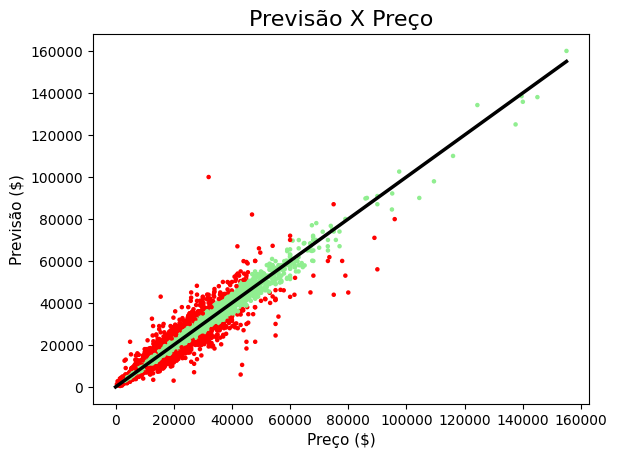

In [42]:
#Importa a biblioteca necessária para visualizarmos graficamente os resultados
import matplotlib.pyplot as plt

#Define a cor dos pontos de acordo com o erro percentual da previsão
colors = np.where(df_comparativo['erro_perc'] > 0.15, 'red', 'lightgreen')

#Define as séries a serem plotadas: preço e previsão
plt.scatter(df_comparativo['preco'], df_comparativo['previsao'],s=5, c=colors)

#Edita os títulos dos eixos e o tamanho de suas fontes
plt.xlabel('Preço ($)', fontsize=11)
plt.ylabel('Previsão ($)', fontsize=11)
plt.title('Previsão X Preço', fontsize=16)

#Define os limites do eixo das abscissas
x = np.linspace(0, max(df_comparativo['preco']))

#Cria uma reta de igualdade (quanto mais próximo desta, melhor a previsão)
y = x

#Plota a reta na cor preta, definindo sua espessura
plt.plot(x, y, color='black', linewidth=2.5)

#Plota o gráfico
plt.show()